In [1]:
from skyfield.api import Star, load, N,S,E,W, wgs84
from skyfield.data import hipparcos
from skyfield import almanac

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load constellation numberes
import json

with open('constellation_hipnums.json') as f:
    constellation_hipps = json.load(f)

In [62]:
def setup():
    
    #load info
    eph = load('de421.bsp') 
    with load.open(hipparcos.URL) as f:
        all_stars = hipparcos.load_dataframe(f)
        
    #create sun, earth, and moon 
    sun = eph['sun']
    earth = eph['earth']
    moon = eph['moon']
    
    #create timescale
    ts = load.timescale()
    
    return eph, all_stars, sun, earth, moon, ts






def set_location(lat, latD, lon, lonD, elevation_m):
    #create location
    
    location = earth + wgs84.latlon(lat * latD, lon * lonD, elevation_m=elevation_m)
    
    return location






def make_star(hipp_num, all_stars):
    
    star = Star.from_dataframe(all_stars.loc[hipp_num])
    
    return star







def get_object_info(obj, location, time):
    
    #get alt, az, and dist of specified object at particular time & place 
    #time as ts.utc()
    
    obj_observe = location.at(time).observe(obj)
    obj_app = obj_observe.apparent()
    
    alt, az, dist = obj_app.altaz()
    
    return alt, az, dist



def obj_over_time(obj, location, times):
    
    #get list of alt, az, and dist of object at location during all times listed ts.utc()
    alts = []
    azs = []
    dists = []
    
    for time in times:
        alt, az, dist = get_object_info(obj, location, time)
        alts.append(alt)
        azs.append(az)
        dists.append(dist)
        
    return alts, azs, dists



def altaz_to_polar(alt, az):
    
    #stereographic projection
    
    if alt >= 0:
        r = np.sin(alt + np.pi/2) / (1 - np.cos(alt + np.pi/2))
    else:
        r = -(alt) / (np.pi/2) + 1
         
    theta = az
    
    return r, theta


def make_constellation(all_stars, hipps):
    
    const = []
    for hip in hipps:
        #print(hip)
        star = make_star(hip, all_stars)
        
        const.append(star)
        #print(star)
        
    return const
    
    
    
def get_constellations(all_stars, const_hipps):
    
    #make stars for all constellations and put into dictionary based on const name 
    
    consts = {}
    for key, value in const_hipps.items():
        consts[key] = make_constellation(all_stars, value)
    
    return consts




def get_all_constellations_info(const, location, time): 
    
    #get altaz & dist for each star in each constellation, at ONE timeslice 
    #save as "constellation": [[alt, az, dist], [alt, az, dist], ...... ]
    
    const_info = {}
    for star_name, stars in const.items():
        #print("get all", const[star_name])
        const_info[star_name] = get_constellation_info(stars, location, time)
    
    
    return const_info 

def get_constellation_info(star_list, location, time):
    
    #get list of [[alt, az, dist], [alt, az, dist], ...] for ONE constellation at ONE timeslice
    all_info = []
    for star in star_list:
        #print("get const", star)
        info = get_object_info(star, location, time)
        all_info.append(info)
    
    return all_info


def get_info_slice(location, time, sun, moon, constellations):
    
    #get info on sun, moon, and all constellations at ONE time 
    sun_info = get_object_info(sun, location, time)
    moon_info = get_object_info(moon, location, time)
    const_info = get_all_constellations_info(constellations, location, time)
    
    return sun_info, moon_info, const_info #sun and moon as [alt, az, dist], const as dictionary
    
    

In [2127]:
#sort constellation names by number 

P_names = []
B_names = []
K_names = []
W_names = []
R_names = []
for name, lists in constellation_hipps.items():
    if name[0] == "P":
        P_names.append(name)
        
    elif name[0] == "B":
        B_names.append(name)
        
    elif name[0] == "K":
        K_names.append(name)
        
    elif name[0] == "W":
        W_names.append(name)
        
    elif name[0] == "R":
        R_names.append(name)
        
P_names.sort(key=lambda x: int(x.split("-")[1]))
B_names.sort(key=lambda x: int(x.split("-")[1]))
K_names.sort(key=lambda x: int(x.split("-")[1]))
W_names.sort(key=lambda x: int(x.split("-")[1]))
R_names.sort(key=lambda x: int(x.split("-")[1]))

In [1820]:
eph, all_stars, sun, earth, moon, ts = setup() #load setup stuff

kaifeng = set_location(34.795, N, 114.345, E, 75) #set location 


constellations = get_constellations(all_stars, constellation_hipps) #make all constellations

In [2147]:
constellations = get_constellations(all_stars, constellation_hipps) #make all constellations

In [2148]:
northpole = set_location(90, N, 135, W, 147)

In [2155]:
#get constellation, sun, moon info for every hour of ONE day

year = 2000
month = 12
day = 20

loc = northpole

times = []

for hour in range(0, 24):
    time = ts.utc(year, month, day, hour)
    times.append(time)


#get altaz for all timeslicese
all_sun_info = []
all_moon_info = []
all_const_info = []

for time in times:
    sun_info, moon_info, const_info = get_info_slice(loc, time, sun, moon, constellations)
    all_sun_info.append(sun_info)
    all_moon_info.append(moon_info)
    all_const_info.append(const_info)

    
#convert altaz to r, theta 
sun_rs = []
sun_thetas = []
moon_rs = []
moon_thetas = []
const_rs = {}
const_thetas = {}

for sun_info in all_sun_info:
    alt, az = sun_info[0:2]
    r, theta = altaz_to_polar(alt.radians, az.radians)
    sun_rs.append(r)
    sun_thetas.append(theta)
    
    
for moon_info in all_moon_info:
    alt, az = moon_info[0:2]
    r, theta = altaz_to_polar(alt.radians, az.radians)
    moon_rs.append(r)
    moon_thetas.append(theta)
    
    
for name, value in all_const_info[0].items():
    num_stars = len(value)
    const_rs[name] = []
    const_thetas[name] = []
    for i in range(num_stars):
        const_rs[name].append([])
        const_thetas[name].append([])
        
#print(const_rs)
        
for const_info in all_const_info:
    for name, stars in const_info.items():
        for i in range(len(stars)):
            star = stars[i]
            alt, az = star[0:2]
            r, theta = altaz_to_polar(alt.radians, az.radians)
            const_rs[name][i].append(r)
            const_thetas[name][i].append(theta)


In [2182]:
hours = [11]


for hour in range(24):

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    for name, rs in const_rs.items():
        thetas = const_thetas[name]

        thisconst_rs = []
        thisconst_thetas = []

        for i in range(len(thetas)):
            star_rs = rs[i]
            star_theta = thetas[i]
            thisconst_rs.append(star_rs[hour])
            thisconst_thetas.append(star_theta[hour])

        if name[0] == "P":
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='purple', markersize=2, linewidth=1)
        
        elif name[0] == "R":            
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='red', markersize=2, linewidth=1)
            
        elif name[0] == "B":            
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='blue', markersize=2, linewidth=1)
            
        elif name[0] == "K":            
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='green', markersize=2, linewidth=1)
            
        elif name[0] == "W":            
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='orange', markersize=2, linewidth=1)
            
        else:            
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='k', markersize=2, linewidth=1)
            
            
    ax.scatter(sun_thetas[hour], sun_rs[hour], color="yellow", s=300, zorder=5)
    ax.scatter(moon_thetas[hour], moon_rs[hour], color='grey', s=300, zorder=5)

    ax.set_rmax(1.75)
    ax.set_theta_offset((10 - hour) * np.pi/12 + np.pi/2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    ax.grid(True, axis="y")
    
    plt.show()
    
    #pltname = str(hour) + "_polaris_nonrotating.png"
    #plt.savefig(pltname, transparent=True, dpi=200, bbox_inches="tight")
    #plt.clf()

/var/folders/rb/vqnffv6d4kx91qbz8_qcwlkh0000gn/T/ipykernel_9448/597539013.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

# STUFF FOR VID MOCKUP

In [ ]:
#TO SEE WHAT THE VIDEO MIGHT LOOK LIKE: 


#get sun & moon position over 1 year (centered on polaris)
#plot sun & moon position over the year, keeping track of rotation 

#get star position info over 1 year (CENTERED ON KAIFENG)
#figure out visibility based on alt (if alt > 0, visible, else not)
#get star position info over 1 year (centered on polaris, for plotting)
#over the year: first, plot all stars as black, keeping track of rotation
        #then, plot ONLY VISIBLE STARS with color, keeping track of rotation 


In [37]:
#get list of times at which to get info 
def get_times(num_days): 

    #increment by 20 minutes
    
    #starting point
    year = 2000
    month = 12
    day = 21
    hour = 1
    min = 51

    times = []
    
    num_hours = num_days * 3 * 24

    for hr in range(num_hours):
        time = ts.utc(year, month, day, hour + (1/3)*hr, min)
        #time = ts.utc(year, month, day, hour + 0.5*hr, min)
        times.append(time)
        
    return times


def get_all_rtheta(loc, times, sun, moon, constellations): #get sun, moon, const rtheta info 
                                                            #at location at times
    
    all_sun_info = []
    all_moon_info = []
    all_const_info = []

    for time in times:
        sun_info, moon_info, const_info = get_info_slice(loc, time, sun, moon, constellations)
        all_sun_info.append(sun_info)
        all_moon_info.append(moon_info)
        all_const_info.append(const_info)
        
    #convert altaz to r, theta 
    sun_rs = []
    sun_thetas = []
    moon_rs = []
    moon_thetas = []
    const_rs = {}
    const_thetas = {}

    for sun_info in all_sun_info:
        alt, az = sun_info[0:2]
        r, theta = altaz_to_polar(alt.radians, az.radians)
        sun_rs.append(r)
        sun_thetas.append(theta)


    for moon_info in all_moon_info:
        alt, az = moon_info[0:2]
        r, theta = altaz_to_polar(alt.radians, az.radians)
        moon_rs.append(r)
        moon_thetas.append(theta)


    for name, value in all_const_info[0].items():
        num_stars = len(value)
        const_rs[name] = []
        const_thetas[name] = []
        for i in range(num_stars):
            const_rs[name].append([])
            const_thetas[name].append([])

    #print(const_rs)

    for const_info in all_const_info:
        for name, stars in const_info.items():
            for i in range(len(stars)):
                star = stars[i]
                alt, az = star[0:2]
                r, theta = altaz_to_polar(alt.radians, az.radians)
                const_rs[name][i].append(r)
                const_thetas[name][i].append(theta)
                
    return sun_rs, sun_thetas, moon_rs, moon_thetas, const_rs, const_thetas

In [5]:
def get_risings_info(times, sun, moon, loc):
    
    #get almanac info for sun
    sunrises, y = almanac.find_risings(loc, sun, times[0], times[-1])
    sunsets, y = almanac.find_settings(loc, sun, times[0], times[-1])
    sunrises_l = [[x, True] for x in sunrises]
    sunsets_l = [[x, False] for x in sunsets]
    sun_events = sunrises_l + sunsets_l
    sun_events.sort(key=lambda x: x[0])
    #print(len(sun_events))
    
    #get almanac info for moon
    moonrises, y = almanac.find_risings(loc, moon, times[0], times[-1])
    moonsets, y = almanac.find_settings(loc, moon, times[0], times[-1])
    moonrises_l = [[x, True] for x in moonrises]
    moonsets_l = [[x, False] for x in moonsets]
    moon_events = moonrises_l + moonsets_l
    moon_events.sort(key=lambda x: x[0])
    
    #figure out pos of sun for each time
    curr_sun = True
    i = 0
    sun_pos = [True]
    #print(sun_pos[0], times[0])
    for time in times[1:]:
        if i < len(sun_events):
            if time > sun_events[i][0]:
                curr_sun = sun_events[i][1]
#                 if curr_sun:
#                     print("sunrise", sun_events[i][0].utc_strftime())
#                 else:
#                     print("sunset", sun_events[i][0].utc_strftime())
                i+= 1
        sun_pos.append(curr_sun)
#         print(sun_pos[-1], time.utc_strftime())
        
#     print()
#     print()
        
    #figure out pos of moon for each time
    curr_moon = True
    i = 0
    moon_pos = [True]
    #print(moon_pos[0], times[0].utc_strftime())
    for time in times[1:]:
        if i < len(moon_events):
            if time > moon_events[i][0]:
                curr_moon = moon_events[i][1]
#                 if curr_moon:
#                     print("moonrise", moon_events[i][0].utc_strftime())
#                 else:
#                     print("moonset", moon_events[i][0].utc_strftime())
                i+=1
        moon_pos.append(curr_moon)
        #print(moon_pos[-1], time.utc_strftime())
        
    return sun_pos, moon_pos

In [6]:

def get_twilight_info(times, eph, loc): 

    #get almanac twi info for kaifeng

    f = almanac.dark_twilight_day(eph, loc)
    twitimes, events = almanac.find_discrete(times[0], times[-1], f)

    #figure out when it starts / ends
    previous_e = f(times[0]).item()
    #print(previous_e)
    twitimes_l = []

    for t, e in zip(twitimes, events):
        tstr = t.utc_strftime()
        if previous_e < e:
            if e == 1:
                twitimes_l.append([t, "night end twilight start"])
                #print(twitimes_l[-1])
            elif e == 4:
                twitimes_l.append([t, "twilight end day start"])
                #print(twitimes_l[-1])

            #print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
        else:
            if e == 3:
                twitimes_l.append([t, "day end twilight start"])
                #print(twitimes_l[-1])
            elif e == 0:
                twitimes_l.append([t, "twilight end night start"])
                #print(twitimes_l[-1])

            #print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
        previous_e = e

    #figure out what percentage each time should be at 
    curr_twi = "day" #starts during the day
    i = 0
    twi_percents = [0.25] #so starts at 0.25
    ind = 1
    for time in times[1:]: 
        if i < len(twitimes_l):
            if time > twitimes_l[i][0]:

                print("twitime     ", twitimes_l[i][0].utc_strftime())
                print("current time", time.utc_strftime())

                flag = twitimes_l[i][1]

                if flag == "day end twilight start":
                    print("\tday ended, INSIDE TWILIGHT")
                    curr_twi = "twi->night"

                elif flag == "twilight end night start":
                    print("\tNIGHT")
                    curr_twi = "night"

                elif flag == "night end twilight start":
                    print("\tnight ended INSIDE TWILIGHT")
                    curr_twi = "twi->day"

                elif flag == "twilight end day start":
                    print("\tDAY")
                    curr_twi = "day"

                print()
                i += 1

        if curr_twi == "day":
            twi_percents.append(0.25)

        elif curr_twi == "night":
            twi_percents.append(1)

        elif curr_twi == "twi->night":
            #calculate what percent of twilight has passed
            #the farther elapsed, the closer to 1
            twilength = twitimes_l[i][0] - twitimes_l[i-1][0]
            twielapsed = time - twitimes_l[i-1][0]
            percent = twielapsed / twilength * 0.75 + 0.25
            twi_percents.append(percent)

        elif curr_twi == "twi->day":
            #the farther elapsed, the closer to 0
            twilength = twitimes_l[i][0] - twitimes_l[i-1][0]
            twielapsed = time - twitimes_l[i-1][0]
            percent = (1 - twielapsed / twilength)*0.75 + 0.25 
            twi_percents.append(percent)

        print(ind, time.utc_strftime(), twi_percents[-1])
        ind += 1
    return twi_percents

# TO PLOT VID MOCKUP

In [2440]:
#SETUP

eph, all_stars, sun, earth, moon, ts = setup() #load setup stuff

kaifeng = set_location(34.795, N, 114.345, E, 75) #set locations
northpole = set_location(90, N, 135, W, 147)

constellations = get_constellations(all_stars, constellation_hipps) #make all constellations

In [38]:
#GET TIMES
times = get_times(24) #get 24 hours of times 

In [2442]:
#for all times, get sun/moon/constellation info at NORTH POLE
sun_r, sun_t, moon_r, moon_t, const_r, const_t = get_all_rtheta(northpole, times, sun, moon, constellations)

In [2443]:
#for all times, get constellation altaz at KAIFENG
all_const_info_kaifeng = []

for time in times: 
    const_info = get_all_constellations_info(constellations, kaifeng, time)
    all_const_info_kaifeng.append(const_info)
    
#get visibility at times info, from KAIFENG
#keep as list of dictionaries, one dictionary per time 
#[starname] = [true, false, false, .... ] keeping track of each star in the constellation
all_visibility_info = []
for const_info in all_const_info_kaifeng: 
    #make dictionary for this timeslice
    visibility_info = {}
    for name, stars in const_info.items(): 
        visibility = []
        for star in stars:
            visibility.append(star[0].radians >= 0)
        visibility_info[name] = any(visibility) #if any star is visible, the whole thing is visible
    all_visibility_info.append(visibility_info)

In [2445]:
#also check visibility of sun / moon
#set alpha of star visibility based on sunup/sundown (smoother transition) ---> fadein from civil to full? 
    #if star is visible...
        #if twilight: fade appropriately (linear)
        #if night: full visibility 
#set alpha of sun based on sunup/sundown (immediate transition)
    #if time is after sundown, darken sun
    #if time is after sunrise, brighten sun 
#set alpha of moon based on moonup/moondown (immediate transition)


#figure out moon phase & plot somehow??? 

In [2446]:
#get sun/moon rising info 
sun_pos, moon_pos = get_risings_info(times, sun, moon, kaifeng)

In [ ]:
#get twi info
kaifeng_loc = wgs84.latlon(34.795*N, 114.345*E, elevation_m=75)
twi_percents = get_twilight_info(times, eph, kaifeng_loc)

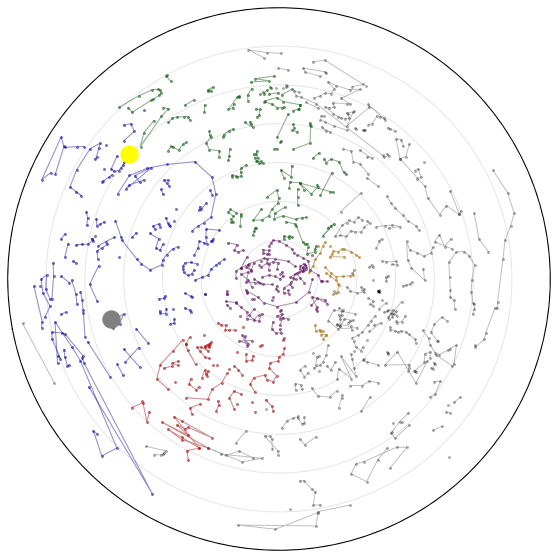

In [2495]:
plot_at_slices(sun_r, sun_t, moon_r, moon_t, const_r, const_t, all_visibility_info, 
               sun_pos, moon_pos, twi_percents, [3], 1.3 , "_vistest_risings_twilights", save=False)

In [2494]:
def plot_at_slices(sun_r, sun_t, moon_r, moon_t, const_r, const_t, vis_info, 
                   sun_pos, moon_pos, twi_percents, slices, offset, filename, save=False):
    
    for hour in slices:

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
        for name, rs in const_r.items():
            thetas = const_t[name]

            thisconst_rs = []
            thisconst_thetas = []

            for i in range(len(thetas)):
                star_rs = rs[i]
                star_theta = thetas[i]
                thisconst_rs.append(star_rs[hour])
                thisconst_thetas.append(star_theta[hour])
                
            
            #first, plot everything in black
            ax.plot(thisconst_thetas, thisconst_rs, "o-", color='k', 
                    markersize=2, linewidth=1, alpha = 0.25)
            
            #then, plot in color IF it's visible (for now, if one is visible, the whole const is visible)
            visibility = vis_info[hour][name]
            
            if visibility:
                a = twi_percents[hour]
                if name[0] == "P":
                    ax.plot(thisconst_thetas, thisconst_rs, "o-", color='purple', 
                            markersize=2, linewidth=1, alpha = a)

                elif name[0] == "R":            
                    ax.plot(thisconst_thetas, thisconst_rs, "o-", color='red', 
                            markersize=2, linewidth=1,  alpha = a)

                elif name[0] == "B":            
                    ax.plot(thisconst_thetas, thisconst_rs, "o-", color='blue', 
                            markersize=2, linewidth=1,  alpha = a)

                elif name[0] == "K":            
                    ax.plot(thisconst_thetas, thisconst_rs, "o-", color='green', 
                            markersize=2, linewidth=1,  alpha = a)

                elif name[0] == "W":            
                    ax.plot(thisconst_thetas, thisconst_rs, "o-", color='orange', 
                            markersize=2, linewidth=1,  alpha = a)

        
        #if sun is visible, plot alpha = 1
        #else, plot alpha = 0.25
        if sun_pos[hour]:
            ax.scatter(sun_t[hour], sun_r[hour], color="yellow", s=300, zorder=5, alpha=1)
        else:
            ax.scatter(sun_t[hour], sun_r[hour], color="yellow", s=300, zorder=5, alpha=0.25)
            
        if moon_pos[hour]:
            ax.scatter(moon_t[hour], moon_r[hour], color='grey', s=300, zorder=5, alpha=1)
        else:
            ax.scatter(moon_t[hour], moon_r[hour], color='grey', s=300, zorder=5, alpha=0.25)
        
        for i in range(1, 8):
            
            if (i<7):
                ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*i*0.25, 
                        color='grey', linestyle='-', zorder=0, linewidth=1, alpha=0.2)
            elif i == 7:
                ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*i*0.25, 
                        color='k', linestyle='-', zorder=0, linewidth=2, alpha=1)

        ax.set_rmax(1.75)
        ax.set_theta_offset((10-hour) * np.pi/48 + np.pi/2 + offset) #lol
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.grid(visible=False)
        #ax.grid(visible=True, axis="y")
        
        if save == False:
            plt.show()
        else:
            pltname = str(hour) + filename + ".png"
            plt.savefig(pltname, transparent=True, dpi=200, bbox_inches="tight")
            plt.clf()

# GETTING ACTUAL INFO

In [ ]:
#what do I actually need????????

#1. visibility over time of all asterisms --> which videos are displayed (non-visible => not shown at all?)
    #all_visibility_info: one dictionary for each time, from KAIFENG info of stars only
    
#2. risings & twilights over time 
    #sun_pos, moon_pos: lists, boolean, one element for each time --> sun/moon visible activation
    #twi_percents: list, float, one element for each time --> opacity of visible videos 
    
#3. sun & moon position over time --> projected from NORTH POLE, for positioning on chart
    #***** do a pared-down animation of this?
            #with only sun, moon, and maybe one asterism to keep track of subtle rotation 
            #over ALL time
            #maybe good idea to include rising/setting

#4. moon phases????????? 
    #use north pole orientation, vertical moon (horizon is outer circle)
    #animate crescent etc. according to phase information
    #moon_phases: list, angles, one for each time
    
    
#save everything, including TIMES, to json / pickle! 

In [ ]:
import json
import pickle

In [42]:
def get_all_visibility_info(constellations, location, time): 
    
    #get altaz & dist for each star in each constellation, at ONE timeslice 
    #save as "constellation": [[alt, az, dist], [alt, az, dist], ...... ]
    
    const_info = {}
    for star_name, stars in constellations.items():
        const_info[star_name] = get_visibility(stars, location, time)
    
    
    return const_info 

def get_visibility(star_list, location, time):
    
    #check stars until you find one visible, OR until all are checked
    
    visible = False 
    i = 0
    while (visible == False) and i < len(star_list):
        star = star_list[i]
        observe = location.at(time).observe(star).apparent()
        alt, az, dist = observe.altaz()
        visible = alt.radians>=0
        i+=1
        
    
    return visible

In [7]:
#SETUP

eph, all_stars, sun, earth, moon, ts = setup() #load setup stuff

kaifeng = set_location(34.795, N, 114.345, E, 75) #set locations
northpole = set_location(90, N, 135, W, 147)

constellations = get_constellations(all_stars, constellation_hipps) #make all constellations

In [39]:
#GET TIMES
times = get_times(366) #every 20 minutes

In [53]:
#save times
import pickle
with open("DATA/times.pickle", "wb") as f:
    pickle.dump(times, f)

In [107]:
#1. VISIBILITY
all_vis_info = []

for i in range:
    time = times[i]
    info = get_all_visibility_info(constellations, kaifeng, time)
    all_vis_info.append(info)
    
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [110]:
with open("DATA/asterism_visibility.pickle", "wb") as f:
    pickle.dump(all_vis_info, f)

In [43]:
#2. RISINGS & TWILIGHTS

#get sun/moon rising info 
sun_pos, moon_pos = get_risings_info(times, sun, moon, kaifeng)

#get twi info
kaifeng_loc = wgs84.latlon(34.795*N, 114.345*E, elevation_m=75)
twi_percents = get_twilight_info(times, eph, kaifeng_loc)

1 2000-12-21 02:11:00 UTC 0.25
2 2000-12-21 02:31:00 UTC 0.25
3 2000-12-21 02:51:00 UTC 0.25
4 2000-12-21 03:11:00 UTC 0.25
5 2000-12-21 03:31:00 UTC 0.25
6 2000-12-21 03:51:00 UTC 0.25
7 2000-12-21 04:11:00 UTC 0.25
8 2000-12-21 04:31:00 UTC 0.25
9 2000-12-21 04:51:00 UTC 0.25
10 2000-12-21 05:11:00 UTC 0.25
11 2000-12-21 05:31:00 UTC 0.25
12 2000-12-21 05:51:00 UTC 0.25
13 2000-12-21 06:11:00 UTC 0.25
14 2000-12-21 06:31:00 UTC 0.25
15 2000-12-21 06:51:00 UTC 0.25
16 2000-12-21 07:11:00 UTC 0.25
17 2000-12-21 07:31:00 UTC 0.25
18 2000-12-21 07:51:00 UTC 0.25
19 2000-12-21 08:11:00 UTC 0.25
20 2000-12-21 08:31:00 UTC 0.25
21 2000-12-21 08:51:00 UTC 0.25
22 2000-12-21 09:11:00 UTC 0.25
twitime      2000-12-21 09:15:18 UTC
current time 2000-12-21 09:31:00 UTC
	day ended, INSIDE TWILIGHT

23 2000-12-21 09:31:00 UTC 0.3800806261738242
24 2000-12-21 09:51:00 UTC 0.54574586518977
25 2000-12-21 10:11:00 UTC 0.7114111042057172
26 2000-12-21 10:31:00 UTC 0.8770763432216631
twitime      2000-12

In [45]:
#save risings & twilights
with open("DATA/sun_updown.json", "w") as f:
    json.dump(sun_pos, f)

with open("DATA/moon_updown.json", "w") as f:
    json.dump(moon_pos, f)
    
with open("DATA/twi_percents.json", "w") as f:
    json.dump(twi_percents, f)

In [46]:
#4. MOON PHASES
moon_phases = []

for time in times:
    phase = almanac.moon_phase(eph, time)
    moon_phases.append(phase.degrees)

In [48]:
#save moon phases 
with open("DATA/moon_phases.json", "w") as f:
    json.dump(moon_phases, f)

In [92]:
#3. SUN MOON POSITION @ NORTH POLE, OVER TIME

#use curved array to account for mini rotations
secret = make_star(62763, all_stars)
sun_r, sun_t, moon_r, moon_t, curv_r, curv_t = get_simple_rtheta(northpole, times, sun, moon, secret)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


1897
1898
1899
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098


3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3801
3802
3803
3804


5298
5299
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499


6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157


8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869


10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
10526
10527
10528
10529
10530
10531
10532
10533
10534
10535
10536
10537
10538
10539
10540
10541
10542
10543
10544
10545
10546
1054

11796
11797
11798
11799
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
11884
11885
11886
11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899
11901
11902
11903
11904
11905
11906
11907
11908
11909
11910
11911
11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923
11924
11925
11926
11927
11928
11929
11930
11931
11932
11933
11934
11935
11936
11937
11938
11939
11940
11941
11942
11943
11944
11945
11946
11947
11948
11949
11950
11951
11952
11953
11954
11955
11956
11957
11958
11959
11960
11961
11962
11963
1196

13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
1342

14652
14653
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
1482

16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
1622

17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627
17628
17629
17630
17631
17632
17633
17634
17635
17636
17637
17638
17639
17640
17641
17642
1764

18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
1907

20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395
20396
20397
20398
20399
20401
20402
20403
20404
20405
20406
20407
20408
20409
20410
20411
20412
20413
20414
20415
20416
20417
20418
20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429
20430
20431
20432
20433
20434
20435
20436
20437
20438
20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
20461
20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
2054

21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
2198

23289
23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23301
23302
23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
23314
23315
23316
23317
23318
23319
23320
23321
23322
23323
23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381
23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23401
23402
23403
23404
23405
23406
23407
23408
23409
23410
23411
23412
23413
23414
23415
23416
23417
23418
23419
23420
23421
23422
23423
23424
23425
23426
23427
23428
23429
23430
23431
23432
23433
23434
23435
23436
23437
23438
23439
23440
23441
23442
23443
23444
23445
23446
23447
23448
23449
23450
23451
23452
23453
23454
23455
23456
2345

24693
24694
24695
24696
24697
24698
24699
24701
24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728
24729
24730
24731
24732
24733
24734
24735
24736
24737
24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748
24749
24750
24751
24752
24753
24754
24755
24756
24757
24758
24759
24760
24761
24762
24763
24764
24765
24766
24767
24768
24769
24770
24771
24772
24773
24774
24775
24776
24777
24778
24779
24780
24781
24782
24783
24784
24785
24786
24787
24788
24789
24790
24791
24792
24793
24794
24795
24796
24797
24798
24799
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810
24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
2486

26073
26074
26075
26076
26077
26078
26079
26080
26081
26082
26083
26084
26085
26086
26087
26088
26089
26090
26091
26092
26093
26094
26095
26096
26097
26098
26099
26101
26102
26103
26104
26105
26106
26107
26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119
26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
26135
26136
26137
26138
26139
26140
26141
26142
26143
26144
26145
26146
26147
26148
26149
26150
26151
26152
26153
26154
26155
26156
26157
26158
26159
26160
26161
26162
26163
26164
26165
26166
26167
26168
26169
26170
26171
26172
26173
26174
26175
26176
26177
26178
26179
26180
26181
26182
26183
26184
26185
26186
26187
26188
26189
26190
26191
26192
26193
26194
26195
26196
26197
26198
26199
26201
26202
26203
26204
26205
26206
26207
26208
26209
26210
26211
26212
26213
26214
26215
26216
26217
26218
26219
26220
26221
26222
26223
26224
26225
26226
26227
26228
26229
26230
26231
26232
26233
26234
26235
26236
26237
26238
26239
26240
2624

In [93]:
#save sun and moon (and secret) r aand thetas, just in case 

with open("DATA/sun_r.json", "w") as f:
    json.dump(sun_r, f)

with open("DATA/sun_theta.json", "w") as f:
    json.dump(sun_t, f)
    
with open("DATA/moon_r.json", "w") as f:
    json.dump(moon_r, f)
    
with open("DATA/moon_theta.json", "w") as f:
    json.dump(moon_t, f)
    
with open("DATA/secret_r.json", "w") as f:
    json.dump(curv_r, f)

with open("DATA/secret_theta.json", "w") as f:
    json.dump(curv_t, f)

In [94]:
len(sun_r)

26352

In [97]:

plot_sun_moon(sun_r, sun_t, moon_r, moon_t, curv_r, curv_t, sun_pos, moon_pos, 
             range(10), 1.3, "_sun_moon_motion.png", save=True)

6.127773761749268


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [88]:
def plot_sun_moon(sun_r, sun_t, moon_r, moon_t, curv_r, curv_t, sun_pos, moon_pos, 
                  slices, offset, filename, save=False):
    
    for hour in slices:

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    
    
        #plot sun and moon 
        
        if sun_pos[hour]:
            ax.scatter(sun_t[hour], sun_r[hour], color="yellow", s=300, zorder=5, alpha=1)
        else:
            ax.scatter(sun_t[hour], sun_r[hour], color="yellow", s=300, zorder=5, alpha=0.25)
            
        if moon_pos[hour]:
            ax.scatter(moon_t[hour], moon_r[hour], color='grey', s=300, zorder=5, alpha=1)
        else:
            ax.scatter(moon_t[hour], moon_r[hour], color='grey', s=300, zorder=5, alpha=0.25)
        
        ax.scatter(curv_t[hour], curv_r[hour], color="red", s=5, zorder=5, alpha=1)
        
        #plot outer circle 
        ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*7*0.25, 
                        color='k', linestyle='-', zorder=0, linewidth=2, alpha=1)

        ax.set_rmax(1.75)
        ax.set_theta_offset((10-hour) * np.pi/36 + np.pi/2 + offset) #lol
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.grid(visible=False)
        #ax.grid(visible=True, axis="y")
        
        if save == False:
            plt.show()
        else:
            pltname = "DATA/sun_moon_motion/"+ str(hour) + filename + ".png"
            plt.savefig(pltname, transparent=True, dpi=200, bbox_inches="tight")
            plt.clf()

In [91]:
def get_simple_rtheta(loc, times, sun, moon, secret): #get sun, moon, const rtheta info 
                                                            #at location at times
    

    #convert altaz to r, theta 
    sun_rs = []
    sun_thetas = []
    moon_rs = []
    moon_thetas = []
    secret_rs = []
    secret_thetas = []
    
    
    for i in range(len(times)):
        time = times[i]
        sun_info = get_object_info(sun, loc, time)
        sun_alt, sun_az = sun_info[0:2]
        sun_r, sun_theta = altaz_to_polar(sun_alt.radians, sun_az.radians)
        sun_rs.append(sun_r)
        sun_thetas.append(sun_theta) 
        
        moon_info = get_object_info(moon, loc, time)
        moon_alt, moon_az = moon_info[0:2]
        moon_r, moon_theta = altaz_to_polar(moon_alt.radians, moon_az.radians)
        moon_rs.append(moon_r)
        moon_thetas.append(moon_theta)

        secret_info = get_object_info(secret, loc, time)
        secret_alt, secret_az = secret_info[0:2]
        secret_r, secret_theta = altaz_to_polar(secret_alt.radians, secret_az.radians)
        secret_rs.append(secret_r)
        secret_thetas.append(secret_theta)
        
        if i % 100:
            print(i)
                
    return sun_rs, sun_thetas, moon_rs, moon_thetas, secret_rs, secret_thetas

In [2176]:
#get movement over one day
year = 2000
month = 7
day = 20

#make times
times = []

for hour in range(24):
    time = ts.utc(year, month, day, hour)
    times.append(time)
    
#get altaz info over time for multiple objects 
objs = [sun, moon, emperor, pol]
obj_alts = []
obj_azs = []
obj_dists = []

for obj in objs:
    alts, azs, dists = obj_over_time(obj, kaifeng, times)
    obj_alts.append(alts)
    obj_azs.append(azs)
    obj_dists.append(dists)
    

#convert to stereographic projection 
obj_rs = []
obj_thetas = []

for alts, azs in zip (obj_alts, obj_azs):
    rs = []
    thetas = []
    for alt, az in zip(alts, azs):
        r, theta = altaz_to_polar(alt.radians, az.radians)
        rs.append(r)
        thetas.append(theta)
        
    obj_rs.append(rs)
    obj_thetas.append(thetas)

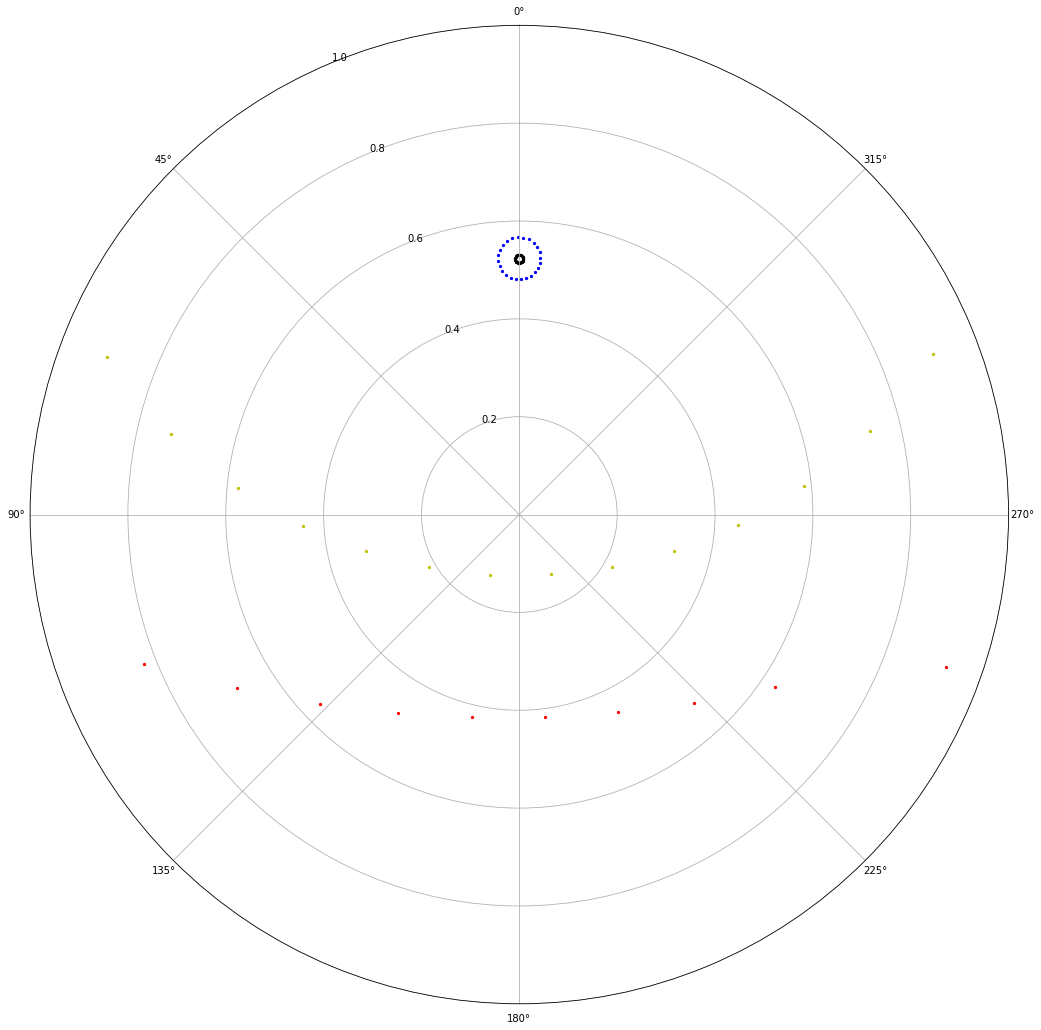

In [101]:
#plot
fig, ax = plt.subplots(figsize=(18, 18), subplot_kw={'projection': 'polar'})

colors = ['y', 'r', 'b', 'k']

for rs, thetas, color in zip(obj_rs, obj_thetas, colors):
    ax.scatter(thetas, rs, color=color, s= 5)
    
ax.set_rmax(1)
ax.set_theta_zero_location("N")

In [135]:
picked_days = []

for i in range(53):
    day = 1 + i*7
    picked_days.append(day)

In [2160]:
#get sun lines & moon lines every hour of every day of one year

year = 2000
days = []
loc = northpole

for day in range(1, 367):
    day = ts.utc(year, 1, day, range(0, 24))
    days.append(day)
    
    

sun_all_alts = []
sun_all_azs = []
sun_all_rs = []
sun_all_thetas = []

moon_all_alts = []
moon_all_azs = []
moon_all_rs = []
moon_all_thetas = []

moon_all_phases = []

for day in days:
    sun_alts, sun_azs, sun_dists = get_object_info(sun, loc, day)
    sun_rs, sun_thetas = altaz_to_polar(sun_alts.radians, sun_azs.radians)
    sun_all_alts.append(sun_alts)
    sun_all_azs.append(sun_azs)
    sun_all_rs.append(sun_rs)
    sun_all_thetas.append(sun_thetas)
    
    moon_alts, moon_azs, moon_dists = get_object_info(moon, loc, day)
    moon_rs, moon_thetas = altaz_to_polar(moon_alts.radians, moon_azs.radians)
    moon_all_alts.append(moon_alts)
    moon_all_azs.append(moon_azs)
    moon_all_rs.append(moon_rs)
    moon_all_thetas.append(moon_thetas)
    
    moon_phase = almanac.moon_phase(eph, day)
    moon_all_phases.append(moon_phase)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [220]:
#combine into one large list 

sun_rs_combined = []
sun_thetas_combined = []

for rs, thetas in zip(sun_all_rs, sun_all_thetas):
    for r, theta in zip(rs, thetas):
        sun_rs_combined.append(r)
        sun_thetas_combined.append(theta)
        
        
moon_rs_combined = []
moon_thetas_combined = []

moon_phases_combined = []

for rs, thetas, phases in zip(moon_all_rs, moon_all_thetas, moon_all_phases):
    for r, theta, phase in zip(rs, thetas, phases.degrees):
        moon_rs_combined.append(r)
        moon_thetas_combined.append(theta)
        moon_phases_combined.append(phase)

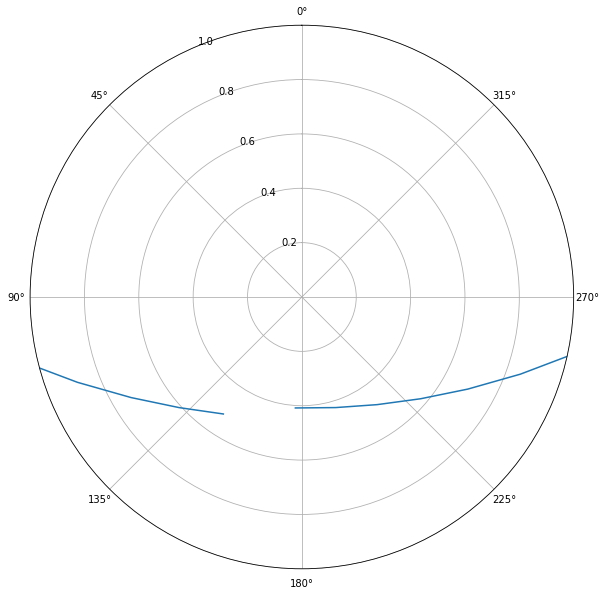

In [206]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

#plot as a spiral
#ax.scatter(sun_thetas_combined, sun_rs_combined)

#for sun_rs, sun_thetas in zip(sun_all_rs, sun_all_thetas):
    #ax.scatter(sun_thetas, sun_rs)
    
slice = 28
    
for moon_rs, moon_thetas in zip(moon_all_rs[:1], moon_all_thetas[:1]):
    ax.plot(moon_thetas, moon_rs)
    
ax.set_rmax(1)
ax.set_theta_zero_location("N")

In [88]:
#get sun alt & az for every minute of one day (UTC style) 

kaifeng = earth + wgs84.latlon(34.795*N, 114.345*E, elevation_m=75)


year = 2000
month = 7
day = 20
location = kaifeng


#first, get all minutes of particular day
times = []



for hour in range(24):
    #for minute in range(60):
        #time = ts.utc(year, month, day, hour, minute)
        
        #times.append(time)
        
    time = ts.utc(year, month, day, hour)
    times.append(time)
        
        
#then, get sun pos for every minute of that day at particular location 
s_alts = []
s_azs = []

m_alts = []
m_azs = []

for time in times:
    sun_observe = location.at(time).observe(sun)
    sun_app = sun_observe.apparent() 
    
    alt, az, dist = sun_app.altaz()
    
    s_alts.append(alt.radians)
    s_azs.append(az.radians)
    
    moon_observe = location.at(time).observe(moon)
    moon_app = moon_observe.apparent()
    
    alt, az, dist = moon_app.altaz()
    
    m_alts.append(alt.radians)
    m_azs.append(az.radians)
    
    
    
#fix negative altitudes (below the horizon)
s_alts_hz = []

for alt in s_alts:
    
    s_alts_hz.append(-alt)

In [89]:
#convert to stereographic polar coords 

s_Rs = []
s_Thetas = []

m_Rs = []
m_Thetas = []

for alt, az in zip(s_alts, s_azs):
    R = np.sin(alt + np.pi/2) / (1 - np.cos(alt + np.pi/2))
        
        
    Theta = az
    
    s_Rs.append(R)
    s_Thetas.append(Theta)
    
for alt, az in zip(m_alts, m_azs):
    R = np.sin(alt + np.pi/2) / (1 - np.cos(alt + np.pi/2))
        
        
    Theta = az
    
    m_Rs.append(R)
    m_Thetas.append(Theta)

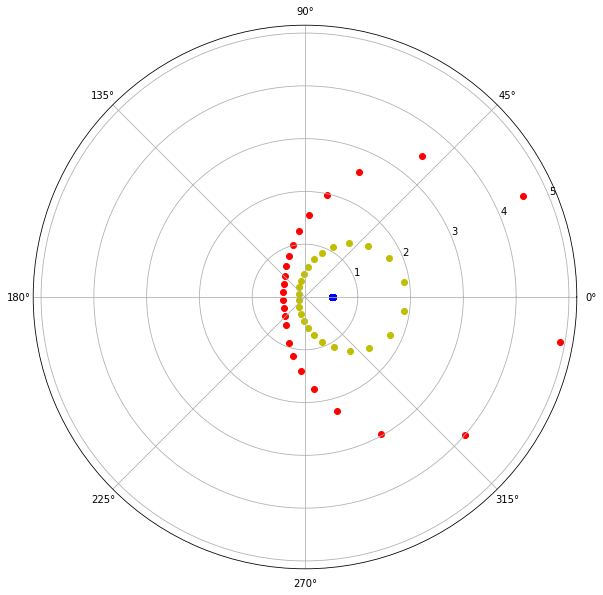

In [90]:
#plot polar stereographic 

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
ax.scatter(s_Thetas, s_Rs, color="y")
ax.scatter(m_Thetas, m_Rs, color="r")
ax.scatter(emp_thetas, emp_rs, color='b')

In [20]:
#remove altitudes below horizon
s_alts_hr = []
for alt in s_alts: 
    if alt <= 0:
        s_alts_hr.append(0)
    else:
        s_alts_hr.append(alt)
        
#flip altitudes for stereographic projection 
s_alts_flipped = []

for alt in s_alts_hr:
    s_alts_flipped.append(-alt)

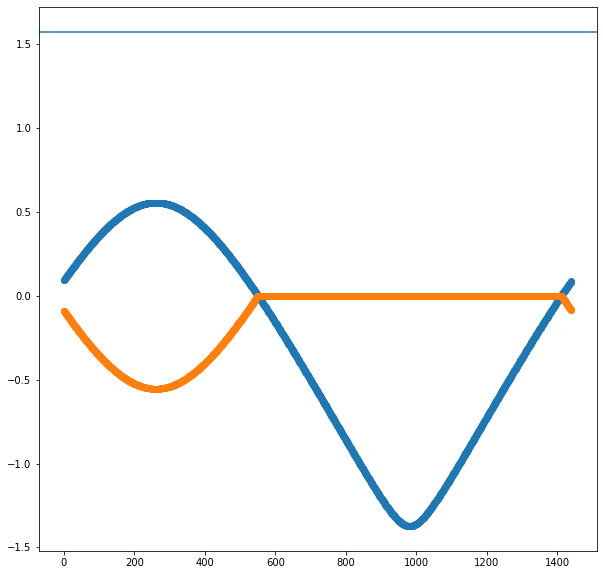

In [27]:
#plot altitude over time
x = np.arange(1440)
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(x, s_alts)
ax.scatter(x, s_alts_flipped)
plt.axhline(np.pi/2)

In [43]:
x

array([   0,    1,    2, ..., 1437, 1438, 1439])